In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import numpy as onp

import haiku as hk
from jax.experimental import optix

from nsec.datasets.two_moons import get_two_moons
from nsec.utils import display_score_two_moons
from nsec.models.dae.ardae import ARDAE

from functools import partial

Populating the interactive namespace from numpy and matplotlib


##  Defining the analytic target distribution

/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


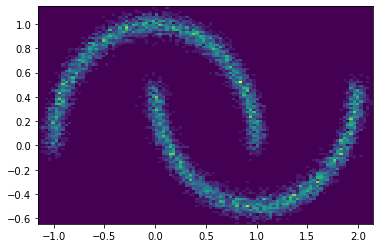

In [2]:
two_moons = get_two_moons(0.05)

rng_key = jax.random.PRNGKey(seed=0)
samps = two_moons.sample(10000, seed=rng_key)

# Plotting samples
hist2d(samps[:,0], samps[:,1],100);

In [3]:
# But now we can also compute the gradients of log p :-)
score = jax.vmap(jax.grad(two_moons.log_prob))

/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


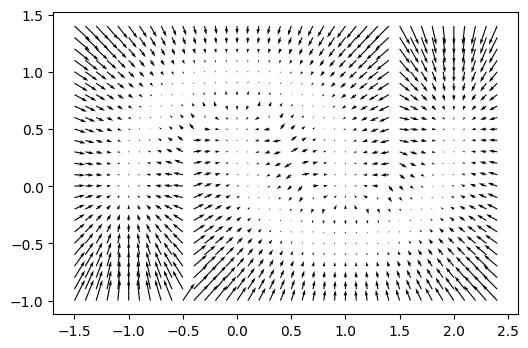

In [4]:
# Close up
figure(dpi=100)
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
g = score(points).reshape([len(Y), len(X),2])

quiver(X, Y, g[:,:,0], g[:,:,1])

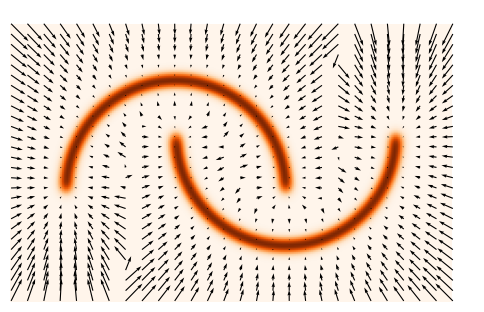

In [5]:
display_score_two_moons(score, two_moons, is_amortized=False, is_reg=False)

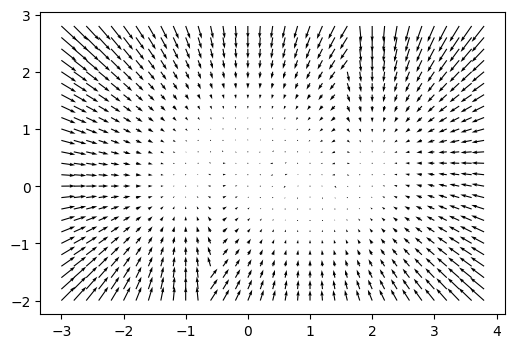

In [6]:
# Large scale
figure(dpi=100)
X = np.arange(-3, 4, 0.2)
Y = np.arange(-2, 3, 0.2)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
g = score(points).reshape([len(Y), len(X),2])

quiver(X, Y, g[:,:,0], g[:,:,1])

## Implementing AR-DAE 

```
class ARDAE(hk.Module):
    def __init__(self, is_training=False):
        super(ARDAE, self).__init__()
        self.is_training=is_training

    def __call__(self, x, sigma):
        sigma = sigma.reshape((-1,1))
        # Encoder
        net = hk.Linear(128)(jnp.concatenate([x, sigma],axis=1))
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(128)(net)
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(2)(net)

        # Decoder
        net = hk.Linear(128)(jnp.concatenate([net, sigma],axis=1))
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(128)(net)
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(2)(net)

        return net
```

In [7]:
def forward(x, sigma, is_training=False):
    denoiser = ARDAE(is_training=is_training)
    return denoiser(x, sigma)

model_train = hk.transform_with_state(partial(forward, is_training=True))


In [8]:
batch_size = 512
delta = 0.05

def get_batch(rng_key):
    y = two_moons.sample(batch_size, seed=rng_key)
    u = onp.random.randn(batch_size, 2)
    s = delta * onp.random.randn(batch_size, 1)
    x = y + s * u
    # x is a noisy sample, y is a sample from the distribution
    # u is the random normal noise realisation
    return {'x':x, 'y':y, 'u':u, 's':s}

In [9]:
optimizer = optix.adam(1e-3)
rng_seq = hk.PRNGSequence(42)

In [10]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
    res, state = model_train.apply(params,  state, rng_key, 
                                   batch['x'], batch['s'])
    loss = jnp.mean((batch['u'] + batch['s'] * res)**2)
    return loss, state

In [11]:
@jax.jit
def update(params, state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    return loss, new_params, state, new_opt_state

In [12]:
params, state = model_train.init(next(rng_seq), 
                                 jnp.zeros((1, 2)), 
                                 jnp.ones((1, 1)))
opt_state = optimizer.init(params)
losses = []

In [13]:
for step in range(2000):
    batch = get_batch(next(rng_seq))
    loss, params, state, opt_state = update(params, state, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(step, loss)

0 1.0240223
100 0.88846934
200 0.8630167
300 0.8550067
400 0.8537699
500 0.8074287
600 0.9468446
700 0.82368875
800 0.9234992
900 0.8697677
1000 0.90154856
1100 0.89286184
1200 0.83306414
1300 0.8426841
1400 0.8668043
1500 0.86872894
1600 0.86801624
1700 0.81205434
1800 0.8616432
1900 0.80901754


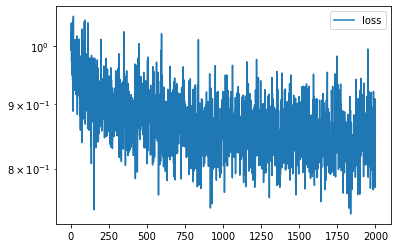

In [14]:
semilogy(np.array(losses[:]), label='loss')
legend()

In [15]:
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

model = hk.transform_with_state(partial(forward, is_training=False))
score = partial(model.apply, params, state, next(rng_seq))

In [16]:
res, state = score(points, 0.0*jnp.ones((len(points),1)))

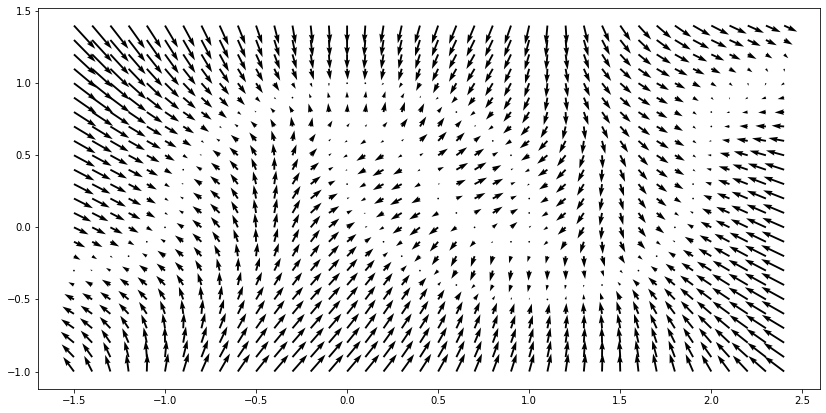

In [17]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

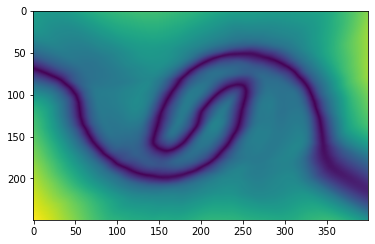

In [18]:
X = np.arange(-1.5, 2.5, 0.01)
Y = np.arange(-1, 1.5, 0.01)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
res, state = score(points, jnp.zeros((len(points),1)))
g = res.reshape([len(Y), len(X),2])
imshow(np.sqrt(g[:,:,0]**2 + g[:,:,1]**2))

/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


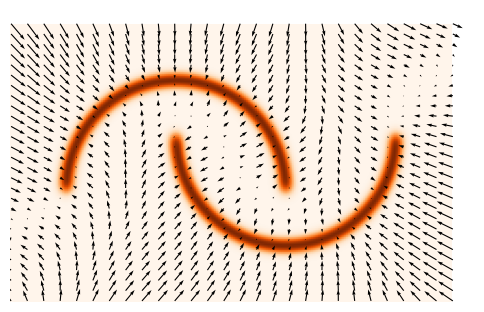

In [20]:
display_score_two_moons(score, two_moons, is_amortized=True, is_reg=True)

In [21]:
X = np.arange(-3, 4, 0.2)
Y = np.arange(-2, 3, 0.2)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

res, state = score(points, 0.0*jnp.ones((len(points),1)))

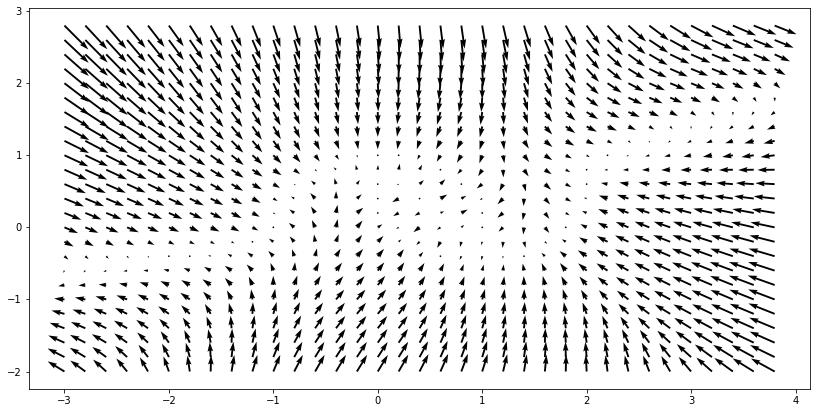

In [22]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

## Adding Lipschitz regularisation

In [23]:
def forward(x, sigma, is_training=False):
    denoiser = ARDAE(is_training=is_training)
    return denoiser(x, sigma)

model_train = hk.transform_with_state(partial(forward, is_training=True))

sn_fn = hk.transform_with_state(lambda x: hk.SNParamsTree(ignore_regex='[^?!.]*b$')(x))

In [24]:
batch_size = 512
delta = 0.05

def get_batch(rng_key):
    y = two_moons.sample(batch_size, seed=rng_key)
    u = onp.random.randn(batch_size, 2)
    s = delta * onp.random.randn(batch_size, 1)
    x = y + s * u
    # x is a noisy sample, y is a sample from the distribution
    # u is the random normal noise realisation
    return {'x':x, 'y':y, 'u':u, 's':s}

In [25]:
optimizer = optix.adam(1e-3)
rng_seq = hk.PRNGSequence(42)

In [26]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
    res, state = model_train.apply(params,  state, rng_key, 
                                   batch['x'], batch['s'])
    loss = jnp.mean((batch['u'] + batch['s'] * res)**2)
    return loss, state

In [27]:
@jax.jit
def update(params, state, sn_state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    
    new_params, new_sn_state = sn_fn.apply(None, sn_state, None, new_params)
    
    return loss, new_params, state, new_sn_state, new_opt_state

In [28]:
params, state = model_train.init(next(rng_seq), 
                                 jnp.zeros((1, 2)), 
                                 jnp.ones((1, 1)))
opt_state = optimizer.init(params)
_, sn_state = sn_fn.init(jax.random.PRNGKey(1), params)

losses = []

In [29]:
for step in range(2000):
    batch = get_batch(next(rng_seq))
    loss, params, state, sn_state, opt_state = update(params, state, sn_state, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(step, loss)

0 0.98122704
100 0.944262
200 0.9279827
300 0.98024184
400 1.0256515
500 0.89538765
600 0.9641553
700 1.0545589
800 1.016612
900 0.9788408
1000 1.0062203
1100 1.006675
1200 1.0096576
1300 0.8936597
1400 0.99052155
1500 0.9201883
1600 0.94545203
1700 0.9792017
1800 1.0148851
1900 0.93748903


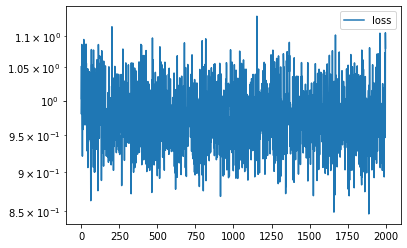

In [30]:
semilogy(np.array(losses[:]), label='loss')
legend()

In [31]:
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

model_sn = hk.transform_with_state(partial(forward, is_training=False))
score_sn = partial(model_sn.apply, params, state, next(rng_seq))

In [32]:
res, state = score_sn(points, 0.0*jnp.ones((len(points),1)))

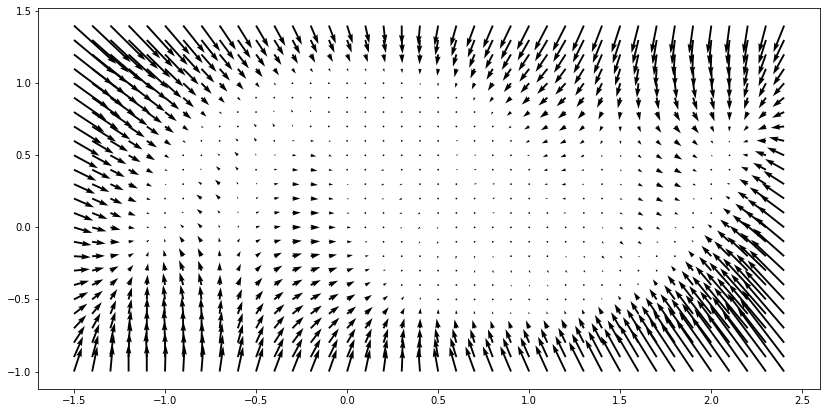

In [33]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


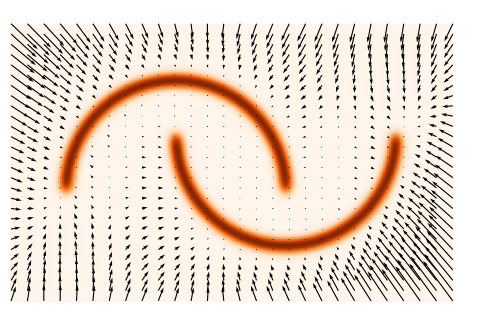

In [34]:
display_score_two_moons(score_sn, two_moons, is_amortized=True, is_reg=True)

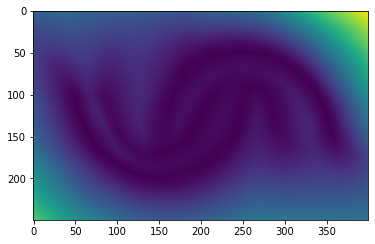

In [35]:
X = np.arange(-1.5, 2.5, 0.01)
Y = np.arange(-1, 1.5, 0.01)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
res, state = score_sn(points, jnp.zeros((len(points),1)))
g = res.reshape([len(Y), len(X),2])
imshow(np.sqrt(g[:,:,0]**2 + g[:,:,1]**2))

In [36]:
X = np.arange(-3, 4, 0.2)
Y = np.arange(-2, 3, 0.2)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

res, state = score_sn(points, 0.0*jnp.ones((len(points),1)))

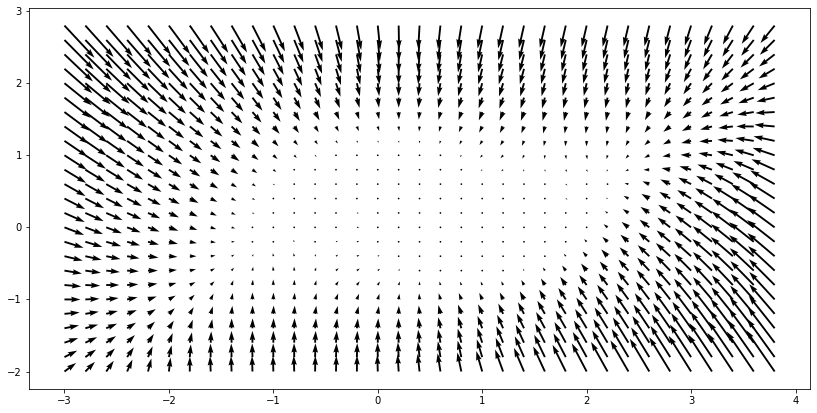

In [37]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])